In [ ]:
# 01 The spelled-out intro to neural networks and backpropagation: building micrograd
# https://youtu.be/VMj-3S1tku0?si=m9g1yyVwRmETgfaz
# https://github.com/karpathy/micrograd
# https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd
# https://karpathy.ai/

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
def f(x):
  return 3*x**2-4*x+5

In [66]:
f(3.0)

20.0

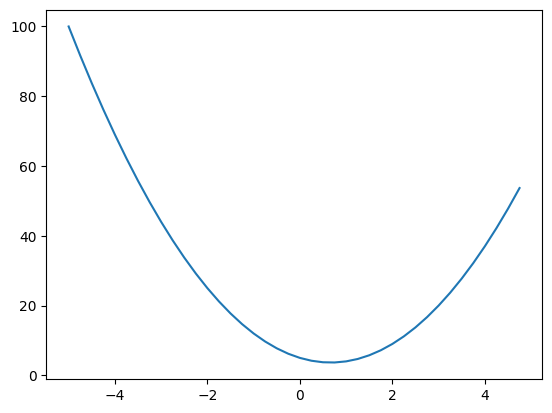

In [67]:
# creates an array of evenly spaced values
# from -5 to 5, step 0.25
xs = np.arange(-5, 5, 0.25)
# apply xs to f
ys = f(xs)
# ys
plt.plot(xs, ys)

In [68]:
# derivative calculation
# https://en.wikipedia.org/wiki/Derivative
h = 0.001
x = 3.0
(f(x+h) - f(x)) / h # slope calculation

14.00300000000243

In [69]:
# more complex case
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [70]:
# calculate derivative
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [71]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # derivative, 0 - no effect
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # fix for a + 1
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # fix for a * 2
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # fallback for multiplication
    return self * other

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  # division a / b is actually:
  # a * (1/b)
  # a * (b**-1)
  def __truediv__(self, other):
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # use power derivative rule
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # topological order all of the children in the graph
    # https://en.wikipedia.org/wiki/Topological_graph
    # https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [72]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [73]:
d._op

'+'

In [74]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

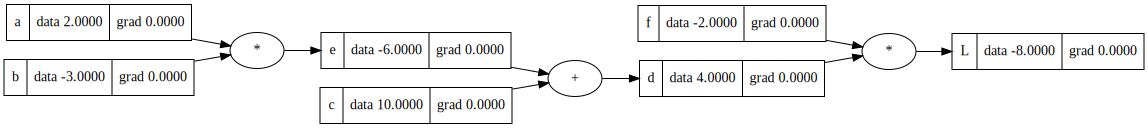

In [75]:
draw_dot(L)

In [76]:
# L = d * f

# dL/dd = ? f

# (f(x+h)-f(x))/h
# (d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h
# h*f/h
# f

In [77]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0 # local grad * d.grad
e.grad = -2.0 # local grad * d.grad
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [78]:
# derive dL / dc derivative L with respect to c
# this is the most important step!!!!

# Calculate local derivatives:
# dd / dc ? 1.0
# d = c + e
# (f(x+h) - f(x)) / h =>
# ((c+h + e) - (c+e)) / h
# (c + h + e - c - e) / h
# (h) / h = 1.0

# dd / de ? 1.0
# d = c + e
# .. same

# Chain rule from Calculus: https://en.wikipedia.org/wiki/Chain_rule
# simply multiply intermediate steps!!!
# local grad * d.grad

# WANT:
# dL / dc = (dL/dd) * (dd/dc) = -2.0 (+ routes derivatives)

# KNOW:
# dL / dd
# dd / dc

# dL / de = -2.0
# WANT:
# dL / da = (dL/de) * (de/da) = see the cell above!
# de / da ? b
# e = a * b
# (b(a+h)-b(a))/h
# (ba + bh - ba) / h
# bh / h
# b

In [79]:
# this is the way how to check manual calculations from the above cell
def lol():
  h = 0.001
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  # just move h and run!
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-3.9999999999995595


In [80]:
# lets try to increase L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# re-run the forward path
e = a * b
d = e + c
L = d * f
print(L.data) # L became more positive, goes up

-7.286496


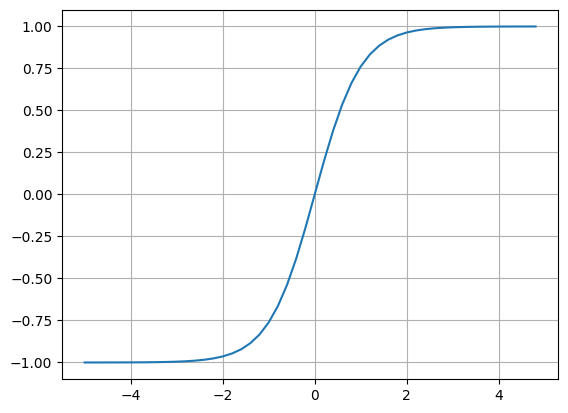

In [81]:
# activation fn
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2)));
plt.grid();

In [82]:
# 2 dimensional neuron with 2 inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# 2 weights: w1, w2 <= synaptic strings for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron - trainable parameter that allows the model better fit the data
# by shifting the activation function
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = raw activation
n = x1w1x2w2 + b; n.label = 'n'
# tanh = hyperbolic tangent fn
o = n.tanh(); o.label = 'o'

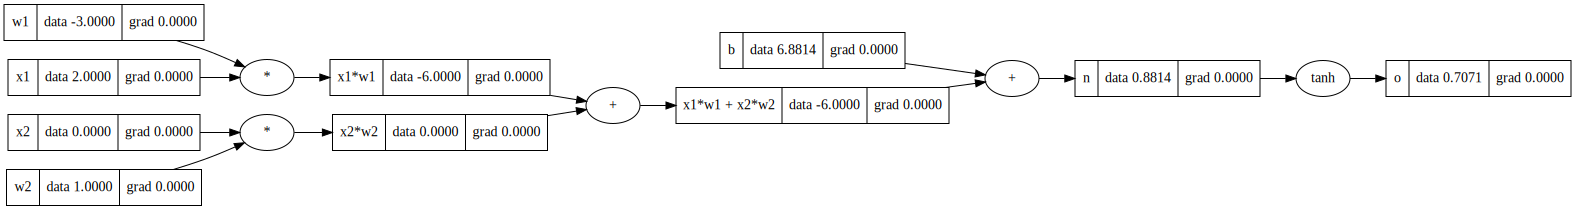

In [83]:
draw_dot(o)

In [84]:
# manual way to apply grad
"""
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
"""

'\no.grad = 1.0\no._backward()\nn._backward()\nb._backward()\nx1w1x2w2._backward()\nx1w1._backward()\nx2w2._backward()\n'

In [85]:
# manual calculations
"""
o.grad = 1.0
n.grad = 1 - o.data**2
b.grad = 0.5 # for + it distributed equally
x1w1x2w2.grad = 0.5 # for + it distributed equally 1 / 2
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad
"""

'\no.grad = 1.0\nn.grad = 1 - o.data**2\nb.grad = 0.5 # for + it distributed equally\nx1w1x2w2.grad = 0.5 # for + it distributed equally 1 / 2\nx1w1.grad = 0.5\nx2w2.grad = 0.5\nx1.grad = w1.data*x1w1.grad\nw1.grad = x1.data*x1w1.grad\nx2.grad = w2.data*x2w2.grad\nw2.grad = x2.data*x2w2.grad\n'

In [86]:
# o = tanh(n)
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# from the wiki:
# do/dn = 1 - tanh(n)**2 => 1-o**2

In [87]:
"""
o.grad = 1.0

# topological graph with topological sort
# https://en.wikipedia.org/wiki/Topological_graph
# https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()
"""

'\no.grad = 1.0\n\n# topological graph with topological sort\n# https://en.wikipedia.org/wiki/Topological_graph\n# https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95\ntopo = []\nvisited = set()\ndef build_topo(v):\n  if v not in visited:\n    visited.add(v)\n    for child in v._prev:\n      build_topo(child)\n    topo.append(v)\nbuild_topo(o)\ntopo\n\nfor node in reversed(topo):\n  node._backward()\n'

In [88]:
o.backward()

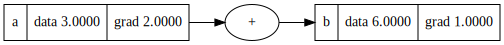

In [89]:
# but there is a hidden bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)
# it does not calculate gradient correctly!
# it happens when we use variable more than once

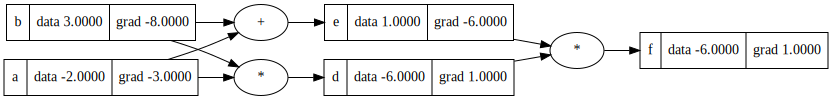

In [90]:
# another example that shows the bug
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

In [91]:
# 2 dimensional neuron with 2 inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# 2 weights: w1, w2 <= synaptic strings for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron - trainable parameter that allows the model better fit the data
# by shifting the activation function
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = raw activation
n = x1w1x2w2 + b; n.label = 'n'
# tanh = hyperbolic tangent fn
# ----
# o = n.tanh(); o.label = 'o'
# let's break tanh to atomic operations
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
# ----
o.backward()

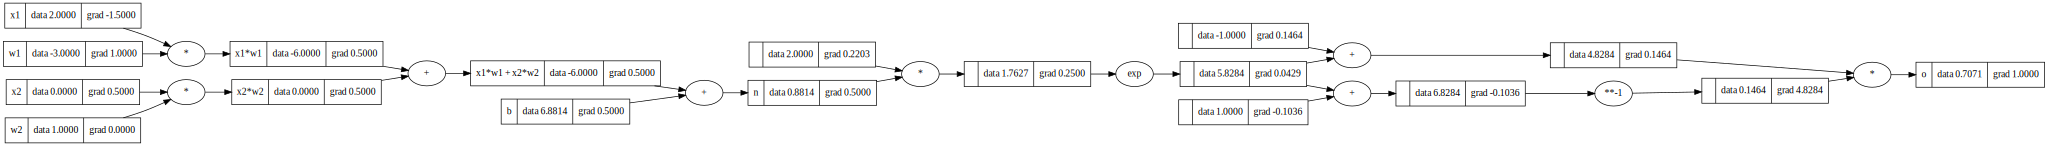

In [92]:
draw_dot(o)

In [93]:
# next we are going to do the same things using pytorch
import torch

x1 = torch.Tensor([2.0]).double()                     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                     ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                     ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()       ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [94]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [95]:
o.item()

0.7071066904050358

In [96]:
import random

# this defines a single neuron
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weight
    self.b = Value(random.uniform(-1,1)) # bias

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

# layer of neurons
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # params = []
    # for neuron in self.neurons:
    #  ps = neuron.parameters()
    #  params.extend(ps)
    # return params
    # or simply
    return [p for neuron in self.neurons for p in neuron.parameters()]

# multi-layer perception
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# one neuron
# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)

# x = [2.0, 3.0]
# n = Layer(2, 3)
# n(x)

# https://cs231n.github.io/neural-networks-1/
# https://cs231n.github.io/assets/nn1/neural_net2.jpeg
#x = [2.0, 3.0, -1.0]
#n = MLP(3, [4, 4, 1])
#n(x)


#  def __call__(self, x):
#    return 0.0

# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)
# 0.0

In [97]:
# https://cs231n.github.io/neural-networks-1/
# https://cs231n.github.io/assets/nn1/neural_net2.jpeg
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6769288115539699)

In [98]:
len(n.parameters())

41

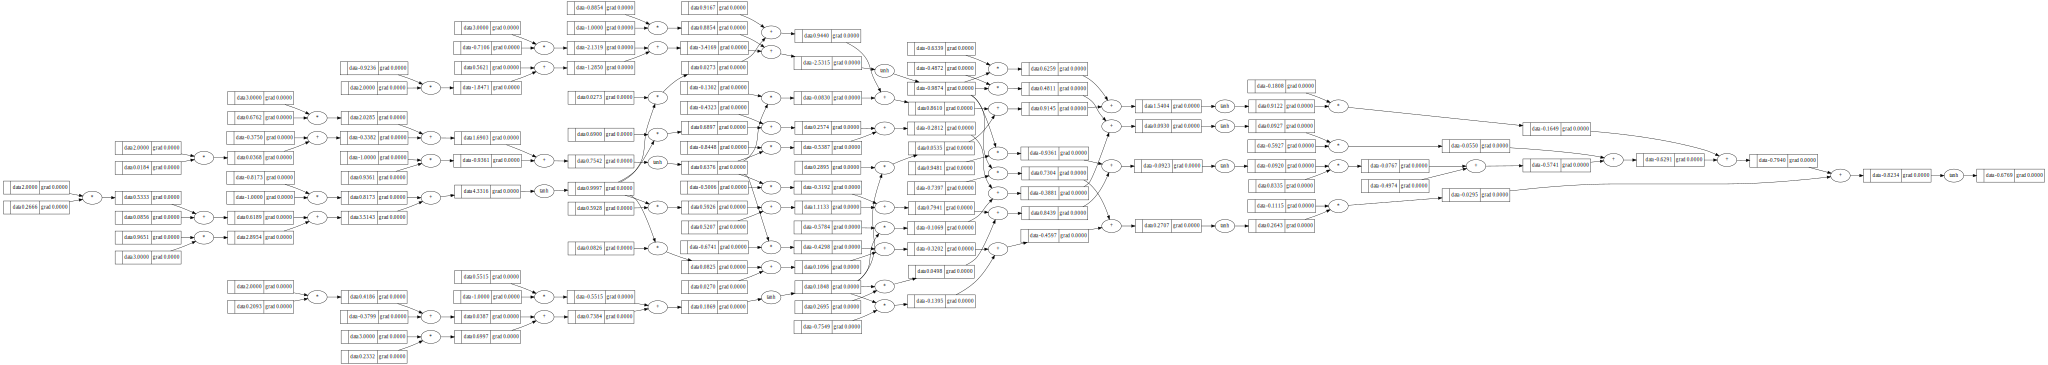

In [99]:
draw_dot(n(x))

In [100]:
# lets create a simple set of neurons:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6769288115539699),
 Value(data=-0.7589054036299965),
 Value(data=-0.539349216062986),
 Value(data=-0.4798338017648243)]

In [101]:
# calculate loss - single number that actually measures how neural network performs!
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)] # mean square loss
# you get 0 when yout is equal to ygt (y ground truth)
# if prediction is not close to 0 (high loss) - it is wrong
# we want a low loss!!!
# low loss = prediction is matching the target!

[Value(data=2.81209023901981),
 Value(data=0.05812660439881492),
 Value(data=0.21219914474178553),
 Value(data=2.189908080845733)]

In [102]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean square loss
loss

Value(data=5.272324069006144)

In [103]:
loss.backward()

In [104]:
n.layers[0].neurons[0].w[0].grad

0.055254112468292024

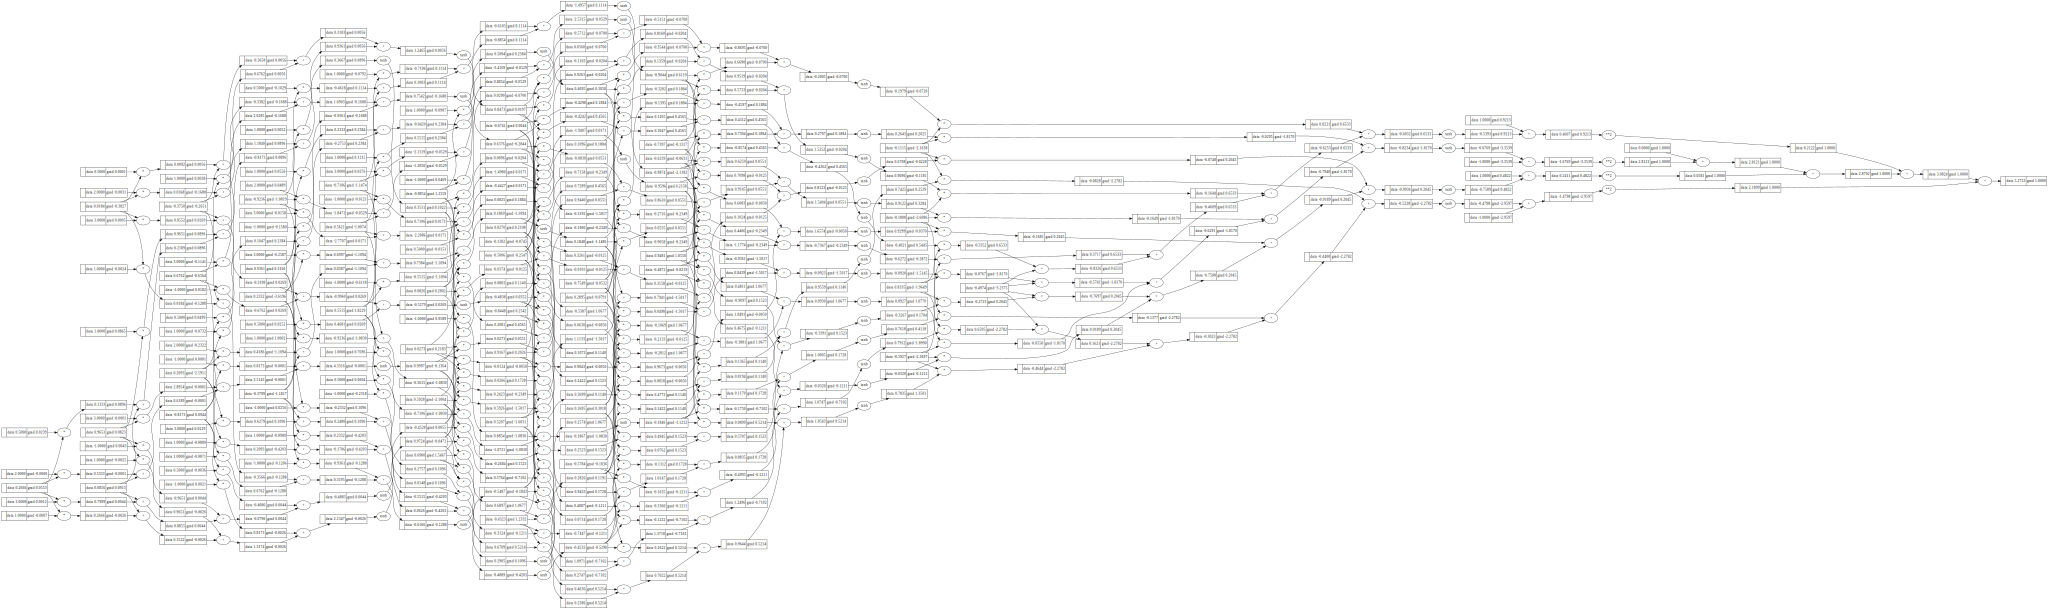

In [105]:
draw_dot(loss)

In [106]:
# =1
# update parameters to reduce loss
for p in n.parameters():
  # 0.01 - is a learning rate
  # it is an art to secelt the right value, if it is too big it can overstep
  # if it is too low - it will take a long time to converge
  p.data += -0.01 * p.grad # - because we want to decrease the loss

In [107]:
n.layers[0].neurons[0].w[0].data

0.2660865164928042

In [108]:
# =2
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean square loss
loss

Value(data=4.510548988000481)

In [109]:
# now we need to iterate the process of updating parameters =1 and re-calculate loss =2
# this is gradient descent
# Gradient descent is an optimization algorithm used to minimize a function by
# iteratively moving in the direction of the steepest descent (i.e., the negative
# of the gradient). It's a foundational technique in machine learning and deep
# learning, often used to train models by minimizing a loss function.

# Imagine you're at the top of a hill and want to get to the bottom. At each
# step, you look around, find the steepest slope downward, and take a step in
# that direction. Repeat this, and ideally, you'll reach the bottom (minimum point).

In [110]:
n.parameters()

[Value(data=0.2660865164928042),
 Value(data=0.9643072867555003),
 Value(data=-0.8182438928966174),
 Value(data=0.08467378316110961),
 Value(data=0.02222809092770401),
 Value(data=0.6827246303546103),
 Value(data=0.9329385928641482),
 Value(data=-0.37236361299772147),
 Value(data=0.23122641032525326),
 Value(data=0.2694265470493877),
 Value(data=0.5332328685740083),
 Value(data=-0.3681166728652845),
 Value(data=-0.9127368314561335),
 Value(data=-0.6991555635023788),
 Value(data=-0.8979695345180667),
 Value(data=0.5721526103678133),
 Value(data=0.6137709270094742),
 Value(data=-0.49808513378793084),
 Value(data=0.26652528013809307),
 Value(data=0.9375112533942013),
 Value(data=0.5367453826642312),
 Value(data=0.6744962800363501),
 Value(data=-0.8473467924449429),
 Value(data=-0.5765808439354608),
 Value(data=-0.4790005266593103),
 Value(data=-0.44462093031516725),
 Value(data=0.025135939381025447),
 Value(data=-0.12942979324947698),
 Value(data=0.2902914704056643),
 Value(data=-0.633248

In [111]:
# init neural network
# lets create a simple set of neurons:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target
# ypred = [n(x) for x in xs]

In [112]:
steps = 20
for k in range(steps):
  # forward path
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean square loss

  # fix for the bug =33
  for p in n.parameters():
    p.grad = 0.0 # reset gradients

  # backward path
  loss.backward()

  # then do an update
  for p in n.parameters():
    # 0.01 - is a learning rate
    # it is an art to secelt the right value, if it is too big it can overstep
    # if it is too low - it will take a long time to converge
    p.data += -0.05 * p.grad # - because we want to decrease the loss

  print(k, loss.data)

0 4.510548988000481
1 2.0399196794680052
2 1.3927592443875292
3 0.9279825772673554
4 0.6274365684088815
5 0.44644723875915276
6 0.3457338732262903
7 0.2800931083695075
8 0.23401200628694496
9 0.20021282600785734
10 0.17451560477832584
11 0.1543961043421816
12 0.138258277906479
13 0.12505120734265027
14 0.11405816217758802
15 0.10477525754849397
16 0.09683880219181173
17 0.08998020921213733
18 0.0839971046514868
19 0.07873428191903845


In [113]:
ypred

[Value(data=0.8353331586778728),
 Value(data=-0.9164783422029478),
 Value(data=-0.824730534268471),
 Value(data=0.8820005917428044)]

In [114]:
# there is a bug in the code :)
# most common neural net mistakes:
# 1) you didn't try to overfit a single batch first.
# 2) you forgot to toggle train/eval mode for the net.
# 3) you forgot to .zero_grad() (in pytorch) before .backward(). <= this is a bug - see =33
# 4) you passed softmaxed outputs to a loss that expects raw logits. ; others? :)
# https://x.com/karpathy/status/1013244313327681536

# why the code worked even with a bug: because it is a very simple problem and
# for neural network it is super easy to fit to this data